In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os

import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder
import yaml

# dimensionality reduction
from cebra import CEBRA
import cebra
import torch

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# GET STIMULUS CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config

data_conf, _ = get_config("silico_neuropixels", "stimulus").values()
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH = data_conf["probe_wiring"]["output"]


# GET STIM-REP CONF
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/stim-rep"
os.chdir(PROJ_PATH)

with open(
    f"conf/silico_npx/stimulus/dataset.yml",
    "r",
    encoding="utf-8",
) as data_conf:
    data_conf = yaml.safe_load(data_conf)

# MODELS
CEBRA_MODEL_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['models']['multilayer_trialwise']

# EMBEDDINGS
CEBRA_EMBED_MTLYR_TRIAL_PATH = data_conf['models']['cebra']['embed']['multilayer_trialwise']

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
N_REP = 50

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi":300} 

2024-05-13 13:29:35,210 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-13 13:29:35,235 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [4]:
def get_stimulus_intervals_ms(epoch_labels, epoch_ms):

    # find stimulus epoch starts and ends
    epoch_end_ms = np.cumsum(epoch_ms)
    epoch_start_ms = np.hstack([0, epoch_end_ms])[:-1]
    df = pd.DataFrame(data=epoch_end_ms)
    df.columns = ["end"]
    df.insert(0, "start", epoch_start_ms)
    df.index = epoch_labels

    # get stimulus intervals
    return [tuple(df.iloc[ix]) for ix in range(len(df)) if df.index[ix] == "stimulus"]


def get_stimulus_labels():
    start = np.arange(0, 360, 10)
    end = np.arange(10, 370, 10)

    stimulus_labels = []
    for ix in range(36):
        stimulus_labels.append(np.repeat(np.arange(start[ix], end[ix], 1), 50))
    return np.array(stimulus_labels).flatten()


def get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
):
    # get epoch timings
    epoch_ms = n_simulations * (
        [start_delay] + n_orientations * n_repeats * [stimulus_duration]
    )
    # get epoch labels
    epoch_labels = n_simulations * (
        ["delay"] + n_orientations * n_repeats * ["stimulus"]
    )

    return {"epoch_labels": epoch_labels, "epoch_ms": epoch_ms}


def get_evoked_responses(spike_trains_ms: np.array, stim_intervals_ms: np.array):
    """_summary_

    Args:
        spike_trains_ms (np.array): _description_
        stim_intervals_ms (np.array): array of tuples (start, end)

    Returns:
        _type_: _description_
    """
    # Use numpy's digitize function to find the bin indices for each value
    bins = [interval[1] for interval in stim_intervals_ms]

    # Return the indices of the bins to which each value in spike_trains_ms belongs.
    bin_indices = np.digitize(spike_trains_ms, bins=bins)

    # Use Counter to count occurrences of bin indices
    interval_counter = Counter(bin_indices)

    # find active stimulus epochs
    active_bin_spike_count = [items[1] for items in list(interval_counter.items())]
    active_bin_ix = [items[0] for items in list(interval_counter.items())]

    # cast unit responses by stimulus epoch in an array
    unit_responses = np.zeros(len(bins))
    unit_responses[active_bin_ix] = active_bin_spike_count
    return unit_responses


def convert_spike_trains_to_ms(spike_trains: np.array, sfreq: int):
    """_summary_

    Args:
        spike_trains (np.array): _description_
        sfreq (int): _description_

    Returns:
        _type_: _description_
    """
    sample_ms = 1 / (sfreq / 1000)
    spike_trains_ms = spike_trains * sample_ms
    return spike_trains_ms


def compute_response_by_stim_matrix(unit_ids, SortingTrueKS3, stimulus_intervals_ms):
    """_summary_

    Args:
        SortingTrueKS3 (_type_): _description_
        stimulus_intervals_ms (_type_): _description_

    Returns:
        _type_: _description_
    """
    SFREQ = SortingTrueKS3.get_sampling_frequency()

    # takes 18 secs
    responses = []
    for unit_id in unit_ids:
        spike_trains = SortingTrueKS3.get_unit_spike_train(unit_id)
        spike_trains_ms = convert_spike_trains_to_ms(spike_trains, SFREQ)
        responses.append(get_evoked_responses(spike_trains_ms, stimulus_intervals_ms))
    return np.array(responses)


import sklearn


# # custom functions
# def split(response, labels, test_ratio):

#     split_idx = int(response.shape[1] * (1 - test_ratio))
#     neural_train = response[:, :split_idx]
#     neural_test = response[:, split_idx:]
#     label_train = labels[:split_idx]
#     label_test = labels[split_idx:]

#     return (
#         neural_train,
#         neural_test,
#         label_train,
#         label_test,
#     )


def split(trial_labels, n_rep, train_ratio: float = 0.8):
    # get 0.80 of trial repeats by direction as train and the remaining trial repeats as test
    train_max_trial_id = int(n_rep * train_ratio)
    train_idx = np.where(trial_labels <= train_max_trial_id)[0]
    test_idx = np.where(trial_labels > train_max_trial_id)[0]
    return (train_idx, test_idx)


def decode(embed_train, embed_test, label_train, label_test):
    """decoding using a k-Nearest Neighbor clustering technique
    We use the fixed number of neighbors 36
    """
    # predict
    decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
    decoder.fit(embed_train, label_train)
    prediction = decoder.predict(embed_test)

    # calculate error
    test_err = np.median(abs(prediction - label_test))
    test_r2 = sklearn.metrics.r2_score(label_test, prediction)
    return test_err, test_r2


def decode_dir_trial_id(embed_train, embed_test, label_train, label_test):
    """decoding using a k-Nearest Neighbor clustering technique
    For a simple demo, we will use the fixed number of neighbors 36.
    """

    dir_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")
    trial_id_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")

    dir_decoder.fit(embed_train, label_train[:, 0])
    trial_id_decoder.fit(embed_train, label_train[:, 1])

    dir_pred = dir_decoder.predict(embed_test)
    trial_id_pred = trial_id_decoder.predict(embed_test)

    prediction = np.stack([dir_pred, trial_id_pred], axis=1)

    # global r2
    test_score = sklearn.metrics.r2_score(label_test[:, :2], prediction)

    # global error
    test_err = np.median(abs(prediction - label_test))
    dir_test_err = np.median(abs(prediction[:, 0] - label_test[:, 0]))
    dir_test_score = sklearn.metrics.r2_score(label_test[:, 0], prediction[:, 0])
    return test_score, test_err, dir_test_err, dir_test_score

### Load dataset

In [5]:
# sorting
SortingTrue = si.load_extractor(GT_SORTING_PATH)

# unit layers
unit_layers = SortingTrue.get_property("layer")
print("# of unit layers:", len(np.unique(unit_layers)))
print("unique unit layers:", np.unique(unit_layers))

# recording
Recording = si.load_extractor(RECORDING_PATH)
print("# of units:", len(SortingTrue.unit_ids))

# get task epoch infos
task = get_task_parameters(
    start_delay=500,
    n_orientations=10,
    n_repeats=50,
    stimulus_duration=200,
    n_simulations=36,
)

# STIMULUS  ***********

# get stimulus labels
stimulus_labels = get_stimulus_labels().astype(float)
print("# of stimulus trials:", len(stimulus_labels))
print("# of stimulus orientations:", len(np.unique(stimulus_labels)))

# get stimulus orientation labels
stimulus_intervals_ms = get_stimulus_intervals_ms(
    task["epoch_labels"], task["epoch_ms"]
)

print("orientations:", stimulus_intervals_ms)

# TRIALS   ***********

trial_labels = np.tile(np.arange(0, N_REP, 1), len(np.unique(stimulus_labels))).astype(
    float
)

# NEURAL RESPONSE ***********

# compute unit x stimulus response matrix
responses = compute_response_by_stim_matrix(
    SortingTrue.unit_ids, SortingTrue, stimulus_intervals_ms
)

# UNIT LABELS ***********

syn = SortingTrue.get_property("synapse_class")
enc = LabelEncoder()
unit_labels = [
    np.array([enc.fit_transform(syn[(unit_layers == "2") | (unit_layers == "3")])])
    .astype(np.float32)
    .T,
    np.array([enc.fit_transform(syn[unit_layers == "4"])]).astype(np.float32).T,
    np.array([enc.fit_transform(syn[unit_layers == "5"])]).astype(np.float32).T,
]

# of unit layers: 6
unique unit layers: ['1' '2' '3' '4' '5' '6']
# of units: 1836
# of stimulus trials: 18000
# of stimulus orientations: 360
orientations: [(500, 700), (700, 900), (900, 1100), (1100, 1300), (1300, 1500), (1500, 1700), (1700, 1900), (1900, 2100), (2100, 2300), (2300, 2500), (2500, 2700), (2700, 2900), (2900, 3100), (3100, 3300), (3300, 3500), (3500, 3700), (3700, 3900), (3900, 4100), (4100, 4300), (4300, 4500), (4500, 4700), (4700, 4900), (4900, 5100), (5100, 5300), (5300, 5500), (5500, 5700), (5700, 5900), (5900, 6100), (6100, 6300), (6300, 6500), (6500, 6700), (6700, 6900), (6900, 7100), (7100, 7300), (7300, 7500), (7500, 7700), (7700, 7900), (7900, 8100), (8100, 8300), (8300, 8500), (8500, 8700), (8700, 8900), (8900, 9100), (9100, 9300), (9300, 9500), (9500, 9700), (9700, 9900), (9900, 10100), (10100, 10300), (10300, 10500), (10500, 10700), (10700, 10900), (10900, 11100), (11100, 11300), (11300, 11500), (11500, 11700), (11700, 11900), (11900, 12100), (12100, 12300)

### (14m) Cebra-Hyb (direction)

* Median error and correlations are higher for cebra direction only.

In [6]:
# reproducibility
torch.manual_seed(0)
np.random.seed(0)

MAX_ITER = 12000
SIZE = 1
LOAD = True

# neural responses by layers
data_l23_exc = responses[(unit_layers == "2") | (unit_layers == "3"), :]
data_l4_exc = responses[(unit_layers == "4"), :]
data_l5_exc = responses[(unit_layers == "5"), :]
data_l6_exc = responses[(unit_layers == "6"), :]

# auxiliary variables
labels = stimulus_labels

if not LOAD:
    # model parameters
    model_cfg = {
        "model_architecture": "offset10-model",  # 10 receptive field
        "batch_size": 1024,
        "temperature_mode": "auto",
        "learning_rate": 0.001,
        "max_iterations": MAX_ITER,
        "conditional": "time_delta",  # supervised
        "time_offsets": 10,  # 1 timestep
        "output_dimension": 3,  # 3 dimensions
        "device": "cuda_if_available",
        "verbose": False,
        "hybrid": True,
    }

    # cebra - hybrid
    cebra_l23_model_dir = CEBRA(**model_cfg)
    cebra_l4_model_dir = CEBRA(**model_cfg)
    cebra_l5_model_dir = CEBRA(**model_cfg)
    cebra_l6_model_dir = CEBRA(**model_cfg)

    # train and save
    cebra_l23_model_dir.fit(data_l23_exc.T, labels.T)
    cebra_l23_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l23.pt"
    )
    cebra_l4_model_dir.fit(data_l4_exc.T, labels.T)
    cebra_l4_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l4.pt"
    )
    cebra_l5_model_dir.fit(data_l5_exc.T, labels.T)
    cebra_l5_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l5.pt"
    )
    cebra_l6_model_dir.fit(data_l6_exc.T, labels.T)
    cebra_l6_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l6.pt"
    )

else:
    cebra_l23_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l23.pt"
    )
    cebra_l4_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l4.pt"
    )
    cebra_l5_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l5.pt"
    )
    cebra_l6_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l6.pt"
    )

# embeddings
cebra_l23_embed_dir = cebra_l23_model_dir.transform(data_l23_exc.T)
cebra_l4_embed_dir = cebra_l4_model_dir.transform(data_l4_exc.T)
cebra_l5_embed_dir = cebra_l5_model_dir.transform(data_l5_exc.T)
cebra_l6_embed_dir = cebra_l6_model_dir.transform(data_l6_exc.T)

# align to L2/3
alignment = cebra.data.helper.OrthogonalProcrustesAlignment()
cebra_l4_embed_dir = alignment.fit_transform(
    cebra_l23_embed_dir, cebra_l4_embed_dir, labels.T, labels.T
)
cebra_l5_embed_dir = alignment.fit_transform(
    cebra_l23_embed_dir, cebra_l5_embed_dir, labels.T, labels.T
)
cebra_l6_embed_dir = alignment.fit_transform(
    cebra_l6_embed_dir, cebra_l6_embed_dir, labels.T, labels.T
)

#### Shuffled

In [10]:
# reproducibility
torch.manual_seed(0)
np.random.seed(0)
shuff_labels_dir = np.random.permutation(labels.T)

if not LOAD:
    # shuffled cebra - behavior model
    shuff_cebra_l23_model_dir = CEBRA(**model_cfg)
    shuff_cebra_l4_model_dir = CEBRA(**model_cfg)
    shuff_cebra_l5_model_dir = CEBRA(**model_cfg)
    shuff_cebra_l6_model_dir = CEBRA(**model_cfg)

    # train and save

    shuff_cebra_l23_model_dir.fit(data_l23_exc.T, shuff_labels_dir)
    shuff_cebra_l23_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l23_shuff.pt"
    )
    shuff_cebra_l4_model_dir.fit(data_l4_exc.T, shuff_labels_dir)
    shuff_cebra_l4_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l4_shuff.pt"
    )
    shuff_cebra_l5_model_dir.fit(data_l5_exc.T, shuff_labels_dir)
    shuff_cebra_l5_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l5_shuff.pt"
    )
    shuff_cebra_l6_model_dir.fit(data_l6_exc.T, shuff_labels_dir)
    shuff_cebra_l6_model_dir.save(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l6_shuff.pt"
    )

else:
    # load
    shuff_cebra_l23_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l23_shuff.pt"
    )
    shuff_cebra_l4_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l4_shuff.pt"
    )
    shuff_cebra_l5_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l5_shuff.pt"
    )
    shuff_cebra_l6_model_dir = cebra.CEBRA.load(
        "/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/stim-rep/models/cebra/models/cebra_hyb_dir_model_l6_shuff.pt"
    )

# embed
shuff_cebra_l23_embed_dir = shuff_cebra_l23_model_dir.transform(data_l23_exc.T)
shuff_cebra_l4_embed_dir = shuff_cebra_l4_model_dir.transform(data_l4_exc.T)
shuff_cebra_l5_embed_dir = shuff_cebra_l5_model_dir.transform(data_l5_exc.T)
shuff_cebra_l6_embed_dir = shuff_cebra_l6_model_dir.transform(data_l6_exc.T)

### Plot

<Figure size 200x100 with 0 Axes>

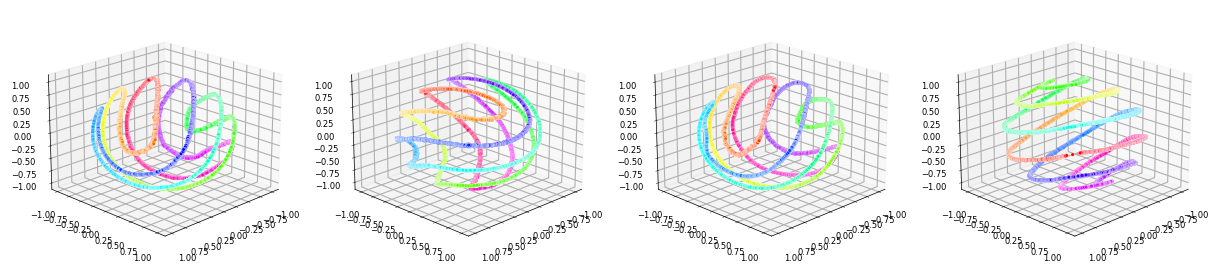

In [8]:
# plot ***********************************************
SIZE = 6


# init plot
plt.set_cmap("hsv")  # circular cmap
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l23_embed_dir[:, 0],
    cebra_l23_embed_dir[:, 1],
    cebra_l23_embed_dir[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l4_embed_dir[:, 0],
    cebra_l4_embed_dir[:, 1],
    cebra_l4_embed_dir[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l5_embed_dir[:, 0],
    cebra_l5_embed_dir[:, 1],
    cebra_l5_embed_dir[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    cebra_l6_embed_dir[:, 0],
    cebra_l6_embed_dir[:, 1],
    cebra_l6_embed_dir[:, 2],
    c=stimulus_labels,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

# save
plt.savefig(PROJ_PATH + "/figures/layers/cebra_hyb_dir_embed.svg", **savefig_cfg)

<Figure size 200x100 with 0 Axes>

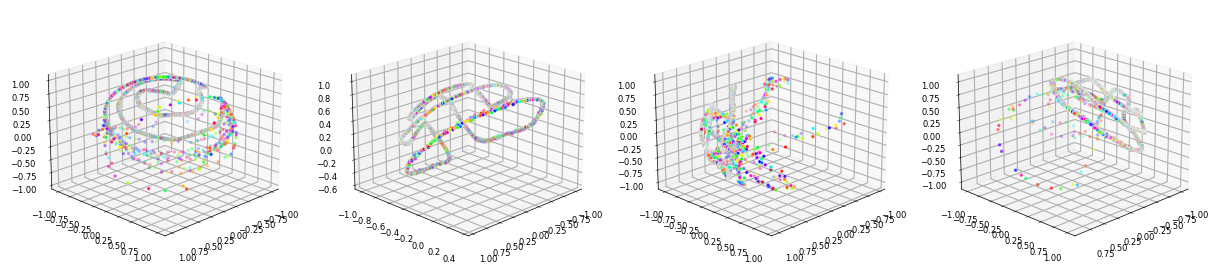

In [11]:
# plot ***********************************************
SIZE = 6


# init plot
plt.set_cmap("hsv")  # circular cmap
fig = plt.figure(figsize=(15, 4))

# plot
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    shuff_cebra_l23_embed_dir[:, 0],
    shuff_cebra_l23_embed_dir[:, 1],
    shuff_cebra_l23_embed_dir[:, 2],
    c=shuff_labels_dir,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    shuff_cebra_l4_embed_dir[:, 0],
    shuff_cebra_l4_embed_dir[:, 1],
    shuff_cebra_l4_embed_dir[:, 2],
    c=shuff_labels_dir,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    shuff_cebra_l5_embed_dir[:, 0],
    shuff_cebra_l5_embed_dir[:, 1],
    shuff_cebra_l5_embed_dir[:, 2],
    c=shuff_labels_dir,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,  # memory efficiency
)

# plot
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.view_init(20, 45, 0)  # elevation, azimuth, roll
scat = ax.scatter(
    shuff_cebra_l6_embed_dir[:, 0],
    shuff_cebra_l6_embed_dir[:, 1],
    shuff_cebra_l6_embed_dir[:, 2],
    c=shuff_labels_dir,
    edgecolors="w",
    linewidths=0.2,
    s=SIZE,
    rasterized=True,
)

# save
plt.savefig(PROJ_PATH + "/figures/layers/cebra_hyb_dir_embed_shuff.svg", **savefig_cfg)

#### Consistency

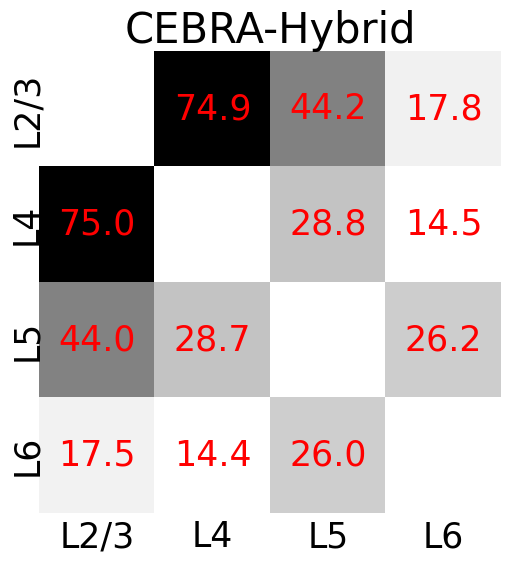

In [19]:
plt.rcParams["font.size"] = 25
fig, ax = plt.subplots(figsize=(6, 6))

dir_scores, dir_pairs, dir_layer = cebra.sklearn.metrics.consistency_score(
    embeddings=[
        cebra_l23_embed_dir,
        cebra_l4_embed_dir,
        cebra_l5_embed_dir,
        cebra_l6_embed_dir,
    ],
    labels=[labels, labels, labels, labels],
    dataset_ids=["L2/3", "L4", "L5", "L6"],
    between="datasets",
)

ax = cebra.plot_consistency(
    dir_scores,
    pairs=dir_pairs,
    datasets=dir_layer,
    ax=ax,
    title="CEBRA-Hybrid",
    colorbar_label=None,
    text_color="r",
)

# save
plt.savefig(PROJ_PATH + "/figures/layers/cebra_hyb_dir_consistency.svg", **savefig_cfg)

#### Causality [TODO]
A prerequisite for performing the Granger Causality test is that the data need to be stationary i.e it should have a constant mean, constant variance, and no seasonal component. Transform the non-stationary data to stationary data by differencing it, either first-order or second-order differencing. Do not proceed with the Granger causality test if the data is not stationary after second-order differencing.

https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html

#### Loss

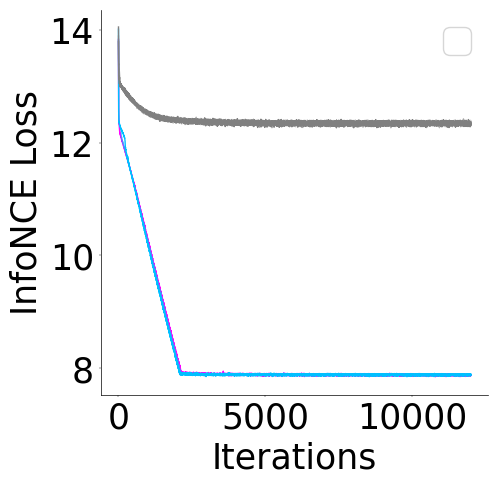

In [20]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(111)

# data
ax = cebra.plot_loss(cebra_l23_model_dir, color="magenta", label="l23", ax=ax)
ax = cebra.plot_loss(cebra_l4_model_dir, color="magenta", alpha=0.3, label="l4", ax=ax)
ax = cebra.plot_loss(
    cebra_l5_model_dir, color="deepskyblue", alpha=0.6, label="l5", ax=ax
)
ax = cebra.plot_loss(cebra_l6_model_dir, color="deepskyblue", label="l6", ax=ax)

# shuffled
ax = cebra.plot_loss(shuff_cebra_l23_model_dir, color="gray", label="l23-shuff", ax=ax)
ax = cebra.plot_loss(
    shuff_cebra_l4_model_dir, color="gray", alpha=0.3, label="l4-shuff", ax=ax
)
ax = cebra.plot_loss(
    shuff_cebra_l5_model_dir, color="gray", alpha=0.6, label="l5-shuff", ax=ax
)
ax = cebra.plot_loss(shuff_cebra_l6_model_dir, color="gray", label="l6-shuff", ax=ax)

# legend
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Iterations")
ax.set_ylabel("InfoNCE Loss")
# plt.legend(bbox_to_anchor=(0.5, 0.3), frameon=False)
plt.legend([])

# save
plt.savefig(PROJ_PATH + "/figures/layers/cebra_hyb_dir_loss.svg", **savefig_cfg)

#### Decoding

In [21]:
train_idx, test_idx = split(trial_labels, n_rep=50, train_ratio=0.2)

# l23
test_err_l23, test_r2_l23 = decode(
    cebra_l23_embed_dir[train_idx, :],
    cebra_l23_embed_dir[test_idx, :],
    stimulus_labels[train_idx],
    stimulus_labels[test_idx],
)
print("\nL2/3")
print(test_err_l23)
print(test_r2_l23)

# shuffled
shuff_test_err_l23, shuff_test_r2_l23 = decode(
    shuff_cebra_l23_embed_dir[train_idx, :],
    shuff_cebra_l23_embed_dir[test_idx, :],
    shuff_labels_dir[train_idx],
    shuff_labels_dir[test_idx],
)
print("shuffled")
print(shuff_test_err_l23)
print(shuff_test_r2_l23)

# L4
test_err_l4, test_r2_l4 = decode(
    cebra_l4_embed_dir[train_idx, :],
    cebra_l4_embed_dir[test_idx, :],
    stimulus_labels[train_idx],
    stimulus_labels[test_idx],
)
print("\nL4")
print(test_err_l4)
print(test_r2_l4)

# shuffled
shuff_test_err_l4, shuff_test_r2_l4 = decode(
    shuff_cebra_l4_embed_dir[train_idx, :],
    shuff_cebra_l4_embed_dir[test_idx, :],
    shuff_labels_dir[train_idx],
    shuff_labels_dir[test_idx],
)
print("shuffled")
print(shuff_test_err_l4)
print(shuff_test_r2_l4)

# L5
test_err_l5, test_r2_l5 = decode(
    cebra_l5_embed_dir[train_idx, :],
    cebra_l5_embed_dir[test_idx, :],
    stimulus_labels[train_idx],
    stimulus_labels[test_idx],
)
print("\nL5")
print(test_err_l5)
print(test_r2_l5)

# shuffled
shuff_test_err_l5, shuff_test_r2_l5 = decode(
    shuff_cebra_l5_embed_dir[train_idx, :],
    shuff_cebra_l5_embed_dir[test_idx, :],
    shuff_labels_dir[train_idx],
    shuff_labels_dir[test_idx],
)
print("shuffled")
print(shuff_test_err_l5)
print(shuff_test_r2_l5)

# L6
test_err_l6, test_r2_l6 = decode(
    cebra_l6_embed_dir[train_idx, :],
    cebra_l6_embed_dir[test_idx, :],
    stimulus_labels[train_idx],
    stimulus_labels[test_idx],
)
print("\nL6")
print(test_err_l6)
print(test_r2_l6)

# shuffled
shuff_test_err_l6, shuff_test_r2_l6 = decode(
    shuff_cebra_l6_embed_dir[train_idx, :],
    shuff_cebra_l6_embed_dir[test_idx, :],
    shuff_labels_dir[train_idx],
    shuff_labels_dir[test_idx],
)
print("shuffled")
print(shuff_test_err_l6)
print(shuff_test_r2_l6)


L2/3
0.16666666666668561
0.9999256918997295
shuffled
89.75
-0.02762305900147144

L4
0.25
0.9998725398921549
shuffled
89.38888888888889
-0.030364521766345964

L5
0.16666666666668561
0.9991989626188621
shuffled
89.63888888888889
-0.027891453034995406

L6
0.16666666666668561
0.9998219943561707
shuffled
89.97222222222223
-0.024083400262108645


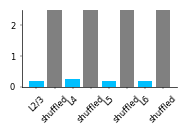

In [25]:
plt.bar(
    x=[1, 2, 3, 4, 5, 6, 7, 8],
    height=[
        test_err_l23,
        shuff_test_err_l23,
        test_err_l4,
        shuff_test_err_l4,
        test_err_l5,
        shuff_test_err_l5,
        test_err_l6,
        shuff_test_err_l6,
    ],
    color=["deepskyblue", "gray"],
)
plt.ylim([0, 2.5])
plt.xticks(
    [1, 2, 3, 4, 5, 6, 7, 8],
    ["L2/3", "shuffled", "L4", "shuffled", "L5", "shuffled", "L6", "shuffled"],
    rotation=45,
)
# save
plt.savefig(PROJ_PATH + "/figures/layers/cebra_hyb_dir_decoding.svg", **savefig_cfg)